# **Quora Question Pair Similarity**

### **Problem statement**
* Predict if the questions asked in Quora are duplicates of the existing questions. 
* This could be useful to instantly provide answers to questions that have already been answered.

### **Mapping real world problem to ML problem**
* Binary Classification problem: In this case study, we predict whether a pair of questions are duplicates or not.

### **Business objectives**
*   The cost of a mis-classification can be high.
    (Customer disappointment if non-duplicates are classified as duplicates)
*   Provide the probability that a pair of questions can be duplicates so that a custom threshold can be chosen.
*   No-strict latency requirements (can take few seconds)
*   Interpretability is partially important. (Not needed for the Customer)

### **Performance metric**
* Binary Cross entropy
* Binary confusion matrix

### **Overview of the Data set**
- Data in train.csv
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate
- Size of Train.csv - 60MB
- Number of rows in Train.csv = 404,290

#### Description of columns:

* qid1 : unique ID of question number 1
* qid2 : unique ID of question number 2
* question1 : Textual content of question1
* question2 : Textual content of question2
* is_duplicate : target variable 
* 0 : Pair of questions are not duplicate
* 1 : Pair of questions are duplicate

Train-Test Split: 
    We build train and test by randomly splitting in the ratio of 70:30

## **Import Libraries**

In [ ]:
# Baisc Libraries
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import random
import datetime

import os
from pathlib import Path
import glob
from tqdm import tqdm

# Text processing Libraries
import re
import nltk
nltk.download("punkt")
nltk.download("stopwords")
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from string import punctuation 
from wordcloud import WordCloud, STOPWORDS

import warnings
warnings.filterwarnings("ignore")
!pip install thefuzz
from thefuzz import fuzz
# from distance import distance

# ML Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.manifold import TSNE

# DL Libraries
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.layers import Embedding, concatenate, LSTM, Dense, BatchNormalization, Dropout
from keras.models import Model

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##**Load Dataset**

In [ ]:
# mounting the drive
from google.colab import drive
drive.mount("/content/drive", force_remount = True)

Mounted at /content/drive


In [ ]:
# change directory
%cd /content/drive/MyDrive/Colab\ Notebooks/ML_CaseStudies/1_Quora/

/content/drive/MyDrive/Colab Notebooks/ML_CaseStudies/1_Quora


In [ ]:
# reading data from csv into data frame
df = pd.read_csv("data/train.csv")
print("No. of data points: ", df.shape[0])
print("No. of Column attributes: ", df.shape[1])
print(list(df.columns))

No. of data points:  404290
No. of Column attributes:  6
['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate']


In [ ]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


## **2. Exploratory Data Analysis**

### 2.1 Check for null values




In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


**Observation**: 

*   "question1" column has 1 null value
*   "question2" column has 2 null values

In [ ]:
# rows with null values
df[df.isna().any(axis=1)]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [ ]:
# fill null values with empty string
df.fillna(" ", inplace=True)

# check if there are any null values left
df[df.isna().any(axis=1)]

,id,qid1,qid2,question1,question2,is_duplicate


### 2.2 Check for duplicate data points

In [ ]:
#check for any duplicate pairs of questions q1 and q2
question_pairs_groups = df[["qid1","qid2","is_duplicate"]].groupby(["qid1","qid2"]).count().reset_index()
print("Number of duplicate pairs:", df.shape[0]-question_pairs_groups.shape[0])

Number of duplicate pairs: 0


### 2.3 Distribution of data points among Class Label (is_duplicate)

In [ ]:
# check number of data points of each class
class_counts = df["is_duplicate"].value_counts()
print(class_counts)

0    255027
1    149263
Name: is_duplicate, dtype: int64


[]

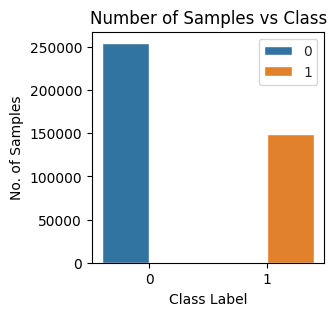

In [ ]:
# plot number of data points of each class label
fig, ax = plt.subplots(figsize=(3,3))
sns.set_style("whitegrid")
sns.barplot(x = class_counts.index, y= class_counts.array, hue = class_counts.index, ax= ax)
ax.set_title("Number of Samples vs Class")
ax.set_xlabel("Class Label")
ax.set_ylabel("No. of Samples")
ax.plot()

In [ ]:
# percentage of class-0 and class-1 data points
print("Percentage of Similar Questions pairs (is_duplicate = 1):\n {}%".format(100*class_counts[1]/(class_counts[0]+class_counts[1])))
print("Percentage of Non Similar Questions pairs (is_duplicate = 0):\n {}%".format(100*class_counts[0]/(class_counts[0]+class_counts[1])))

Percentage of Similar Questions pairs (is_duplicate = 1):
 36.9197853026293%
Percentage of Non Similar Questions pairs (is_duplicate = 0):
 63.0802146973707%


**Observation**: Dataset is imbalanced with Class-1 samples more than Class-0 samples

### 2.4 Repeated questions count
* Number of unique questions in the whole data set
* Number of questions ocuured only once and number of questions repeated more than once

In [ ]:
# Total number of unique questions in the dataset
# number of questions that ocuured only once and 
# number of questions repeated more than once

qids = pd.Series(df["qid1"].to_list() + df["qid2"].to_list())

unique_ids = qids.nunique()
onetime_ids = np.sum(qids.value_counts()== 1)
repeat_ids = np.sum(qids.value_counts()>1)

print("Number of Unique questions: {}" .format(unique_ids))
print("Number of questions(only once): {}" .format(onetime_ids))
print("Number of Repeated questions (more than once): {}".format(repeat_ids))

Number of Unique questions: 537933
Number of questions(only once): 426153
Number of Repeated questions (more than once): 111780


[]

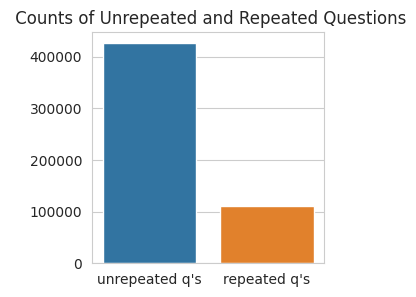

In [ ]:
# plot number of questions occured only once and 
# number of questions repeated more than once

x = ["unrepeated q's", "repeated q's"]
y = [onetime_ids, repeat_ids]

fig, ax = plt.subplots(figsize = (3,3))
sns.set_style("whitegrid")
sns.barplot(x=x,y=y, ax=ax)
ax.set_title(" Counts of Unrepeated and Repeated Questions")
ax.plot()

### 2.5 Distribution of repetition rate of questions

Maximum number of times a single question is repeated: 157



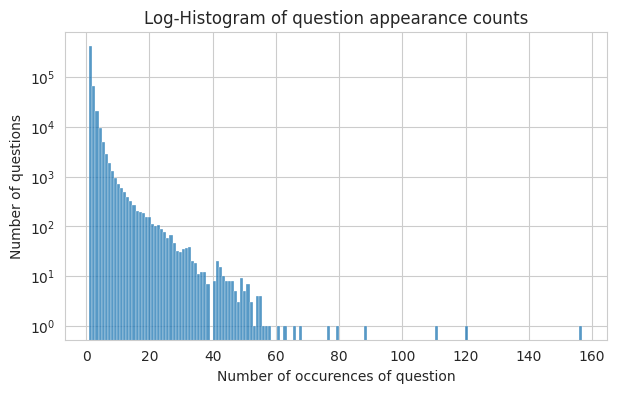

In [ ]:
f, ax = plt.subplots(figsize=(7,4))

sns.histplot(
    qids.value_counts(), 
    bins = 160,
    log_scale=(False,True),
)

ax.set_title("Log-Histogram of question appearance counts")
ax.set_xlabel("Number of occurences of question")
ax.set_ylabel("Number of questions")
ax.plot()

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

## **3.Text Preprocessing**

* convert to lowercase
* Removing html tags
* Expanding contractions etc.
* Removing Punctuations
* Removing Stopwords
* Performing stemming

In [ ]:
def preprocess(text_list):
    """
    To pre-process the text column in the dataframe
    """

    # # load stopwords
    # stoplist = set(stopwords.words('english') + list(punctuation) + ["--"])
    # stemmer = PorterStemmer()

    clean_text_list = []
    for text in tqdm(text_list):

        # convert to lower case
        text = str(text).lower()

        # remove html tags
        text = re.sub(r'<.*>', '', text)

        # removing contractions 
        text = text.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                            .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                            .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                            .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                            .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                            .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                            .replace("€", " euro ").replace("'ll", " will")

        # replacing million with m and thousand with k 
        text = re.sub(r"([1-9]+)000000", r"\1m", text)  # \1 represents replace the first group in the regex command
        text = re.sub(r"([1-9]+)000", r"\1k", text)

        # remove punctuation marks
        text = re.sub(r'[^\w\s]*', '', text)

        ## perform stemming and stop word removal seperately after building the advanced features 
        ## as we use the stopwords information in building some advanced features
        # words = [stemmer.stem(word) for word in word_tokenize(text) if ((word not in stoplist) and (stemmer.stem(word) not in stoplist))]
        # text = " ".join(words)

        clean_text_list.append(text)

    return np.array(clean_text_list)

In [ ]:
def remove_stopwords(text_list):
    """
    To pre-process the text column in the dataframe
    To remove stopwords and perform stemming
    """

    stoplist = set(stopwords.words('english') + list(punctuation) + ["--"])
    clean_text_list = []
    stemmer = PorterStemmer()

    for text in tqdm(text_list):

        # convert to lower case
        text = str(text).lower()

        # stemming and stop word removal seperately after building the advanced features
        words = [stemmer.stem(word) for word in word_tokenize(text) if ((word not in stoplist) and (stemmer.stem(word) not in stoplist))]
        text = " ".join(words)

        clean_text_list.append(text)

    return np.array(clean_text_list)

In [ ]:
# preprocess the text in 'question1' and 'question2'
# Note: not removing stopwords and not performing stemming at this stage 
# bcoz we want to build features based on the info of stop words

process_df = df[["qid1", "qid2", "is_duplicate"]].copy()
process_df["question1"] = preprocess(df["question1"])
process_df["question2"] = preprocess(df["question2"])

100%|██████████| 404290/404290 [00:18<00:00, 22118.72it/s]


In [ ]:
process_df.head(2)

,qid1,qid2,is_duplicate,question1,question2
0,1,2,0,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...
1,3,4,0,what is the story of kohinoor kohinoor diamond,what would happen if the indian government sto...


## **4. Train Test Split**

* Perform Train Test Split before building new features to avoid data leakage.
* Here, we are using data information across the rows to build newfeatures

In [ ]:
# read the x and y from process_df
x, y = process_df[['qid1', 'qid2','question1','question2']], process_df[['is_duplicate']]
# train test split of x and y
x_train, x_test, y_train, y_test = train_test_split(x,y, stratify=y, random_state = 33)

## **5. Building New Features**

### **5.1 Basic Features**

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [ ]:
# functions to build customized features
def normalized_word_Common(row):
    # map(func, iter) is a python function: it applies the function to each element in the iter ==> returns: iter
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
    return 1.0 * len(w1 & w2)

def normalized_word_Total(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * (len(w1) + len(w2))

def normalized_word_share(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))

def basic_features(df):

    # frequency of occurence of each qid in a particular question column across all data points
    # transform produces a same-indexed DataFrame on each group
    df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count')
    df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')

    # sum of frequencies of qid1 and qid2
    df['freq_q1+q2'] = df['freq_qid1'] + df['freq_qid2']
    # absolute difference of frequencies of qid1 and qid2
    df['freq_q1+q2'] = abs(df['freq_qid1'] - df['freq_qid2'])

    # length(ie. number of characters) in each question in each data point
    df['q1len'] = df['question1'].str.len()
    df['q2len'] = df['question2'].str.len()

    # number of words in question1 and question2 in each data point
    df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
    df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

    # features based on number of unique words in question1 and question2
    # axis = 1 means applies function to each row
    df['word_common'] = df.apply(normalized_word_Common, axis=1)
    df['word_total'] = df.apply(normalized_word_Total, axis=1)
    df['word_share'] = df.apply(normalized_word_share, axis=1)

    return df

In [ ]:
# build basic features
x_train_features = basic_features(x_train)
x_test_features = basic_features(x_test)

In [ ]:
x_train_features.head(2)

,qid1,qid2,question1,question2,freq_qid1,freq_qid2,freq_q1+q2,q1len,q2len,q1_n_words,q2_n_words,word_common,word_total,word_share
179028,274801,274802,how many states have their own anthems in india,should india change its national anthem as it ...,1,1,0,47,91,9,16,2.0,25.0,0.08
155911,244152,244153,what are future apps,what is the future of apps,1,1,0,20,26,4,6,3.0,10.0,0.30


####**5.2.1 Analysis of Basic Features**

##### a) Number of questions with a single word

In [ ]:
print ("Minimum length of the questions in question1 : " , min(x_train_features['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(x_train_features['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", x_train_features[x_train_features['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", x_train_features[x_train_features['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 50
Number of Questions with minimum length [question2] : 21


##### b) Analysis of **"word_share"** feature

In [ ]:
# combining x_train and y_train temporarily for plotting purpose
train_df = x_train_features.copy()
train_df['is_duplicate'] = y_train

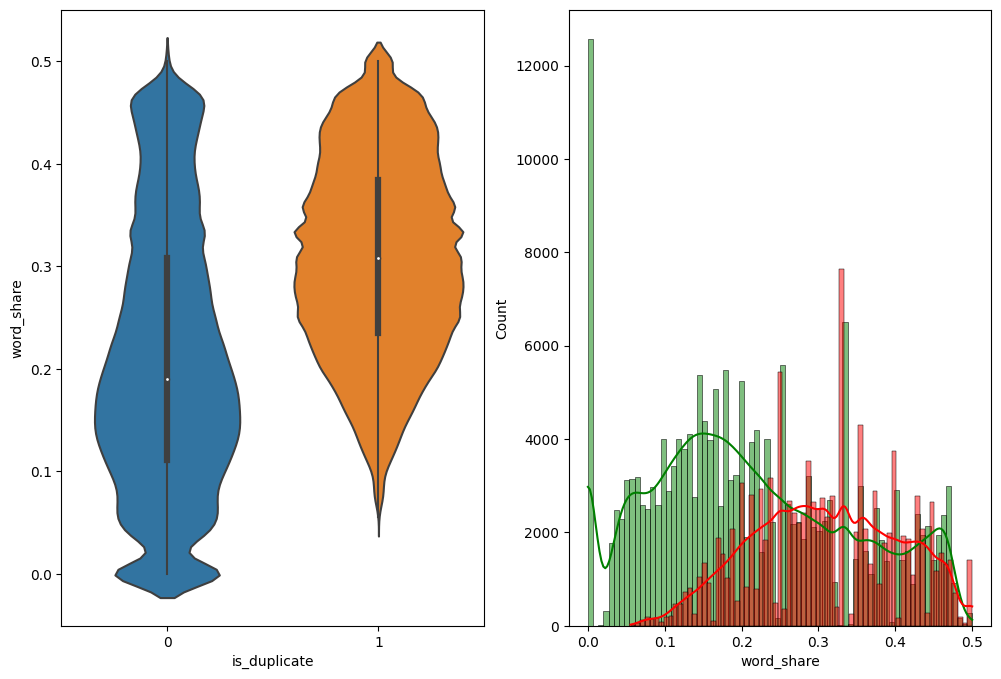

In [ ]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(12, 8))

sns.violinplot(x = 'is_duplicate', y= 'word_share', data = train_df, ax = ax[0])

sns.histplot(train_df[train_df['is_duplicate'] == 0]['word_share'] , label = "0", color = 'green', ax = ax[1], kde =True)
sns.histplot(train_df[train_df['is_duplicate'] == 1.0]['word_share'] , label = "1", color = 'red', ax = ax[1], kde =True)

plt.show()

**Observations of 'word_share' feature:**

1. As the word share, increased the chances of questions being duplicates is higher as observed from the distribution
2.   As there is significant overlap between the distrobution plots of both the class labels, we cannot get a threshold for the classification.



##### c)  Analysis of **"word_common"** feature

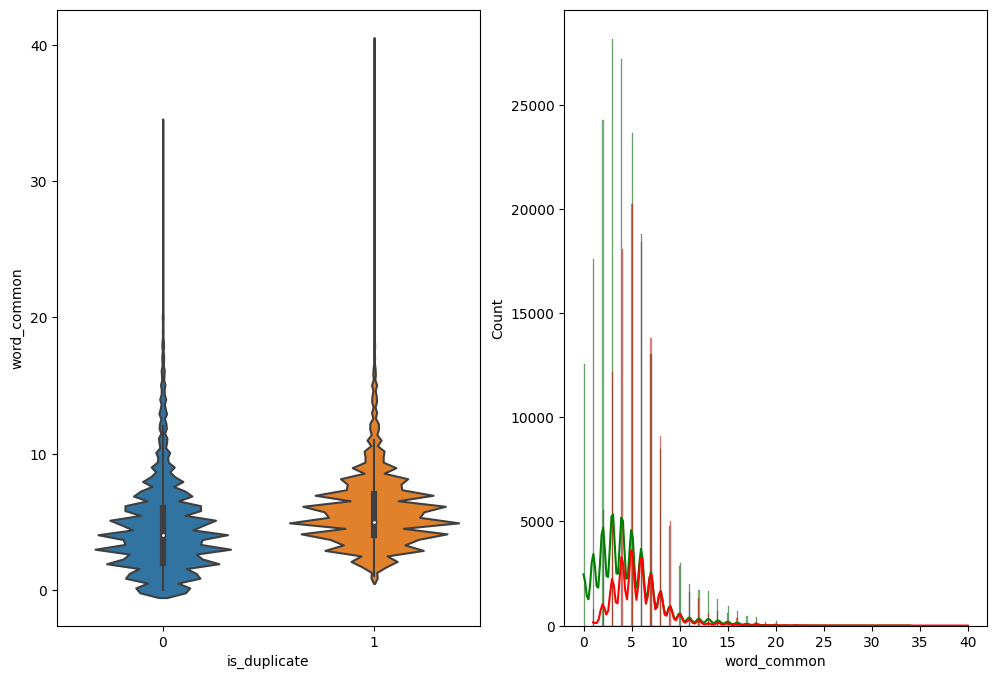

In [ ]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(12, 8))

sns.violinplot(x = 'is_duplicate', y= 'word_common', data = train_df, ax = ax[0])

sns.histplot(train_df[train_df['is_duplicate'] == 0]['word_common'] , label = "0", color = 'green', ax = ax[1], kde =True)
sns.histplot(train_df[train_df['is_duplicate'] == 1.0]['word_common'] , label = "1", color = 'red', ax = ax[1], kde =True)

plt.show()

**Observations of 'word_common' feature:**
* The distributions are highly overlapping. Hence, difficult to infer from this feature alone.

###**5.2 Building Advanced Features**

Definition:
- __Token__: You get a token by splitting sentence with a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>
- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br> 
- __last_word_eq__ :  Check if last word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>
- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>   
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>
- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>

**Fuzzy Wuzzy based Features**:

https://github.com/seatgeek/fuzzywuzzy#usage

http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/

https://github.com/seatgeek/thefuzz

- __fuzz_ratio__ : 
```
>>> fuzz.ratio("this is a test", "this is a test!")
    97
```
- __fuzz_partial_ratio__ :  
```
>>> fuzz.partial_ratio("this is a test", "this is a test!")
    100
```
- __token_sort_ratio__ : 
```
>>> fuzz.ratio("fuzzy wuzzy was a bear", "wuzzy fuzzy was a bear")
    91
>>> fuzz.token_sort_ratio("fuzzy wuzzy was a bear", "wuzzy fuzzy was a bear")
    100
```
- __token_set_ratio__ :
```
>>> fuzz.token_sort_ratio("fuzzy was a bear", "fuzzy fuzzy was a bear")
    84
>>> fuzz.token_set_ratio("fuzzy was a bear", "fuzzy fuzzy was a bear")
    100
```
- __longest_substr_ratio__ :  
Ratio of length of longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))

In [ ]:
SAFE_DIV = 0.0001 

## Custom function to Build token features
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOPWORDS])
    q2_words = set([word for word in q2_tokens if word not in STOPWORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOPWORDS])
    q2_stops = set([word for word in q2_tokens if word in STOPWORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    # cwc_min : Ratio of common_word_count to min length of word count of Q1 and Q2
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    # cwc_min : Ratio of common_word_count to max length of word count of Q1 and Q2
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)

    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    # Absolute difference in number of tokens in both questions
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

### get the Longest Common sub string
# from distance import distance
# def get_longest_substr_ratio(a, b):
#     strs = list(distance.lcsubstrings(a, b))
#     if len(strs) == 0:
#         return 0
#     else:
#         return len(strs[0]) / (min(len(a), len(b)) + 1)

def advanced_features(df):

    # Computing token features and Merging Features with dataset

    print("token features...")
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy

    print("fuzzy features..")

    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string. We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)

    # df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)

    return df

In [ ]:
# build advanced features
x_train_features = advanced_features(x_train_features)
x_test_features = advanced_features(x_test_features)

token features...
fuzzy features..
token features...
fuzzy features..


In [ ]:
x_train_features.columns

Index(['qid1', 'qid2', 'question1', 'question2', 'freq_qid1', 'freq_qid2',
       'freq_q1+q2', 'q1len', 'q2len', 'q1_n_words', 'q2_n_words',
       'word_common', 'word_total', 'word_share', 'cwc_min', 'cwc_max',
       'csc_min', 'csc_max', 'ctc_min', 'ctc_max', 'last_word_eq',
       'first_word_eq', 'abs_len_diff', 'mean_len', 'fuzz_ratio',
       'fuzz_partial_ratio', 'token_set_ratio', 'token_sort_ratio'],
      dtype='object')

#### **5.2.1 Analysis of Advanced Features**

In [ ]:
# combining x_train and y_train temporarily for plotting purpose
train_df = x_train_features.copy()
train_df['is_duplicate'] = y_train

##### a) Pair plot of features:
['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'] 

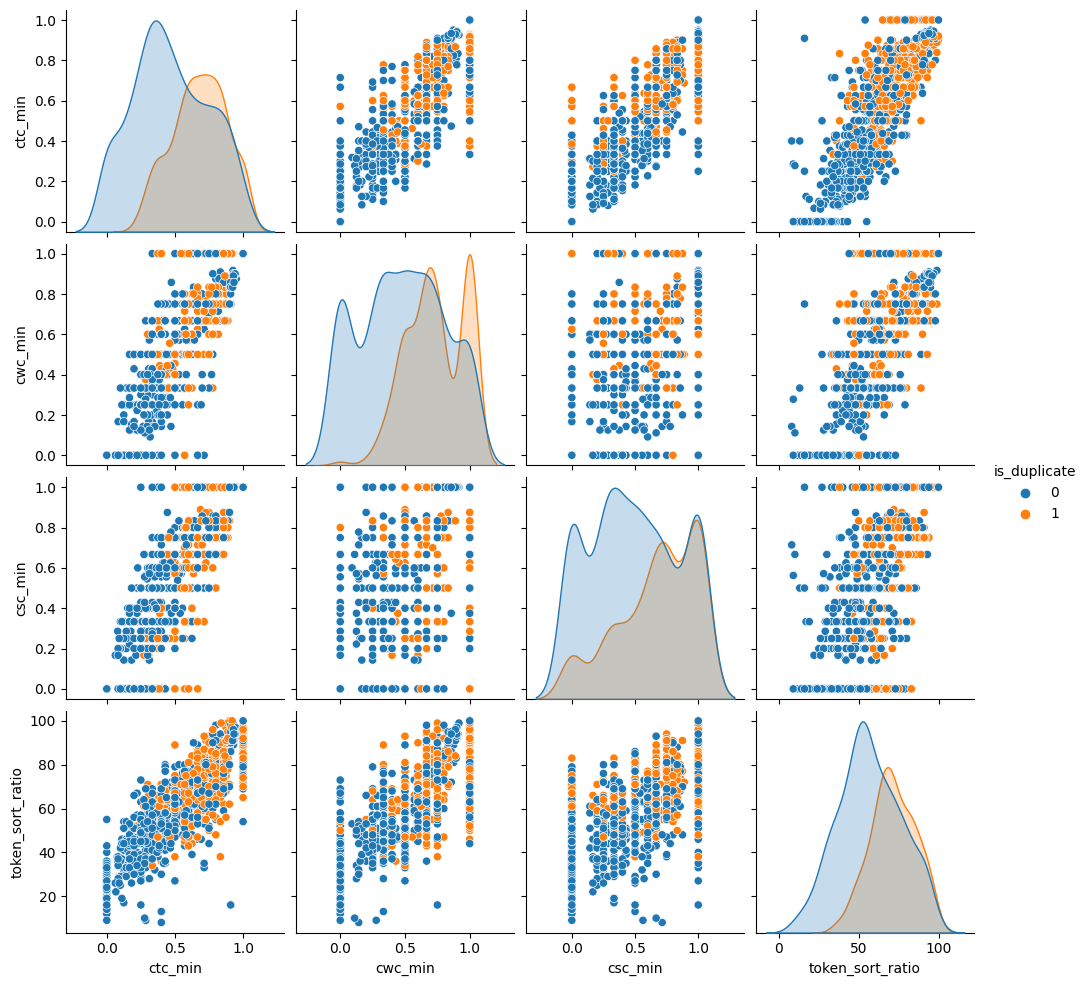

In [ ]:
# n = train_df.shape[0]
n = 1000
sns.pairplot(train_df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

##### b) Analysis of **"token_sort_ratio"** feature

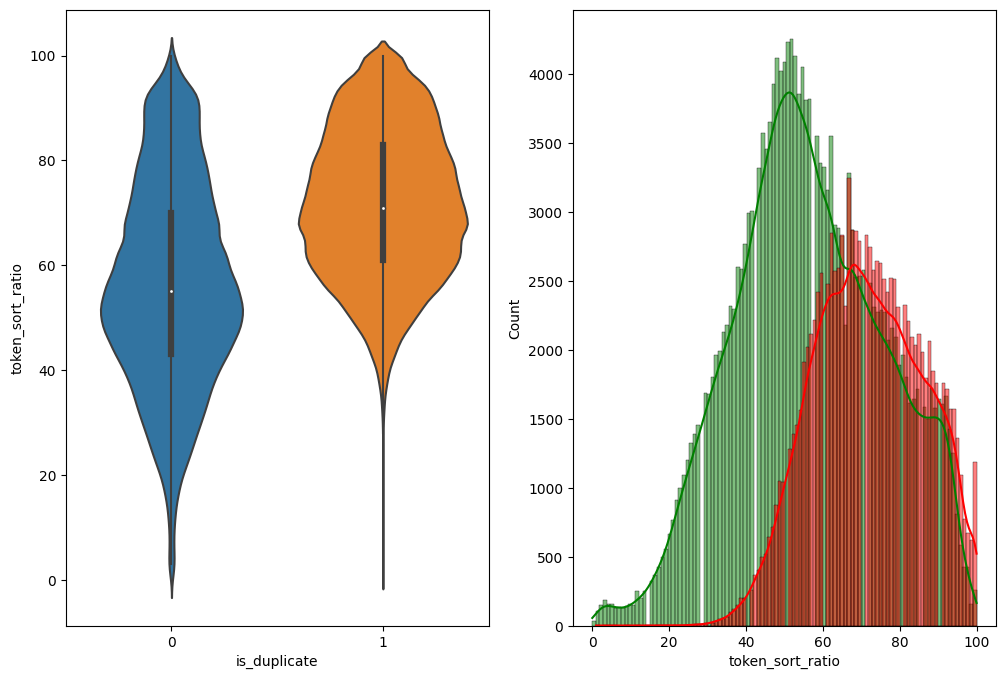

In [ ]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(12, 8))

sns.violinplot(x = 'is_duplicate', y= 'token_sort_ratio', data = train_df, ax = ax[0])

sns.histplot(train_df[train_df['is_duplicate'] == 0]['token_sort_ratio'] , label = "0", color = 'green', ax = ax[1], kde =True)
sns.histplot(train_df[train_df['is_duplicate'] == 1.0]['token_sort_ratio'] , label = "1", color = 'red', ax = ax[1], kde =True)

plt.show()

##### b) Analysis of **"fuzz_ratio"** feature

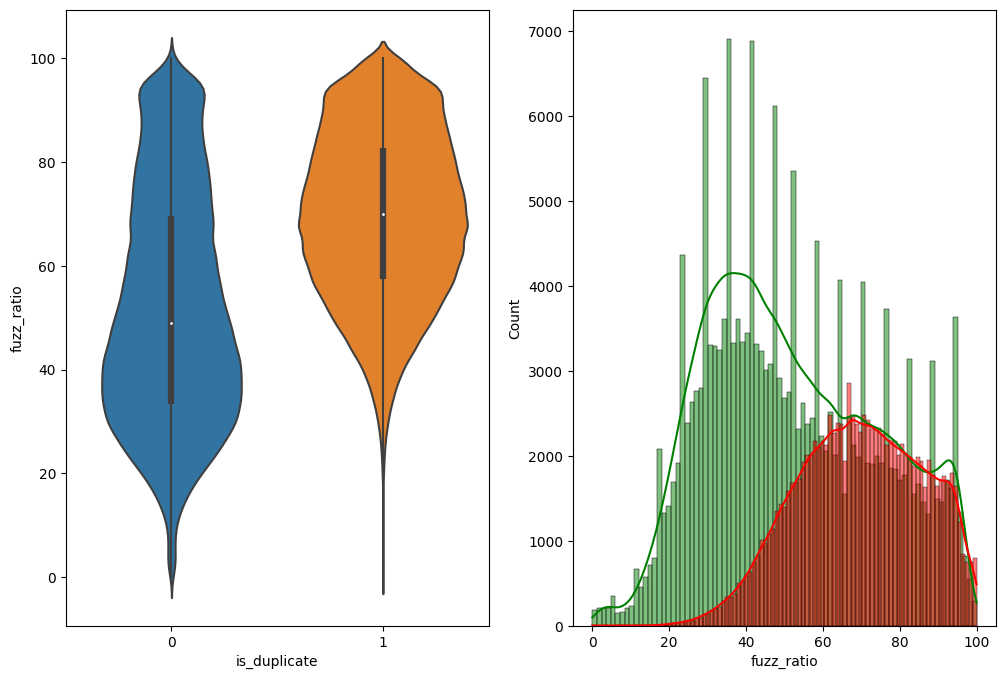

In [ ]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(12, 8))

sns.violinplot(x = 'is_duplicate', y= 'fuzz_ratio', data = train_df, ax = ax[0])

sns.histplot(train_df[train_df['is_duplicate'] == 0]['fuzz_ratio'] , label = "0", color = 'green', ax = ax[1], kde =True)
sns.histplot(train_df[train_df['is_duplicate'] == 1.0]['fuzz_ratio'] , label = "1", color = 'red', ax = ax[1], kde =True)

plt.show()

### **5.3 Remove Stop words from both question1 and question2**

We have already constructed Advanced features. Now we can remove the stop words and perform stemming

In [ ]:
x_train_features['question1'] = remove_stopwords(x_train_features['question1'])
x_train_features['question2'] = remove_stopwords(x_train_features['question2'])

x_test_features['question1'] = remove_stopwords(x_test_features['question1'])
x_test_features['question2'] = remove_stopwords(x_test_features['question2'])

100%|██████████| 101073/101073 [00:42<00:00, 2402.38it/s]


### **5.4 Save Featurized Data in Drive and Load Back** 

In [ ]:
# # save the train and test data frames with customised features into parquet file and load back

files_list = ['x_train_features.parquet',
              'x_test_features.parquet',
              'y_train.parquet',
              'y_test.parquet']

dir_name = "data/"

for file_name in files_list:
    if not os.path.isfile(dir_name+file_name):
        ## to convert the file_name from string format to variable format we use vars() method
        ## Ref: https://thecodingbot.com/use-string-value-as-a-variable-name-in-python/
        vars()[file_name.split(".")[0]].to_parquet(dir_name+file_name)
    else:
        vars()[file_name.split(".")[0]] = pd.read_parquet(dir_name+file_name)

###**5.3 Plotting Word Clouds** 

- Creating Word Cloud of Duplicates and Non-Duplicates Question pairs
- We can observe the most frequent occuring words

In [ ]:
# creating train_df by combining x_train and y_train temporarily for plotting purpose
train_df = x_train_features.copy()
train_df['is_duplicate'] = y_train

In [ ]:
train_df_duplicate = train_df[train_df['is_duplicate'] == 1]
train_df_nonduplicate = train_df[train_df['is_duplicate'] == 0]

# p_words ==> list of all words in q1 and q2, where is_duplicate = 1
# n_words ==> list of all words in q1 and q2, where is_duplicate = 0
# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}

p = np.dstack([train_df_duplicate["question1"], train_df_duplicate["question2"]]).flatten()
n = np.dstack([train_df_nonduplicate["question1"], train_df_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

p_words = " ".join([str(e) for e in p])
n_words = " ".join([str(e) for e in n])

Number of data points in class 1 (duplicate pairs) : 223894
Number of data points in class 0 (non duplicate pairs) : 382540


In [ ]:
stopwords = set(STOPWORDS)
customwords = ["Quora", "said", "br", "best", "will"]
for w in customwords:
    stopwords.add(w)

Word Cloud for Duplicate Question pairs


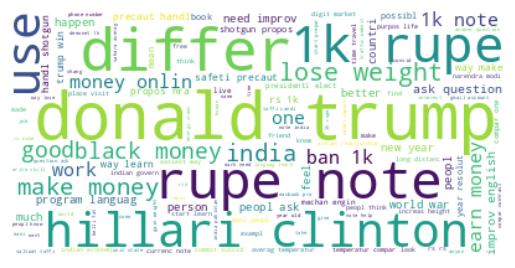

In [ ]:
wc = WordCloud(background_color="white", stopwords=stopwords, max_words=10000)
wc.generate(p_words)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Word Cloud for Non-Duplicate Question pairs


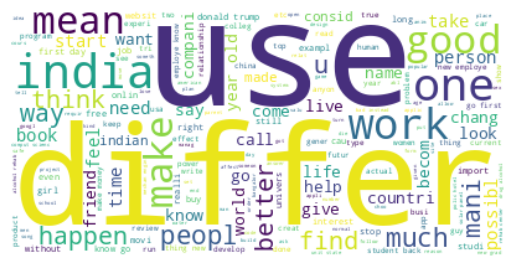

In [ ]:
wc = WordCloud(background_color="white", stopwords=stopwords, max_words=10000)
wc.generate(n_words)
print ("Word Cloud for Non-Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

## **6. TSNE Visualization**
we use customized numerical features that we have constructed from the train dataset

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# sample 10k datapoints from the original data to visualize using tsne
x_train_subsampled = x_train_features[0:10000]

scaler = MinMaxScaler()
X = scaler.fit_transform(x_train_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 
                                             'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 
                                             'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio']])

y = y_train[0:10000]

In [ ]:
from sklearn.manifold import TSNE

tsne_2d = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=30).fit_transform(X)

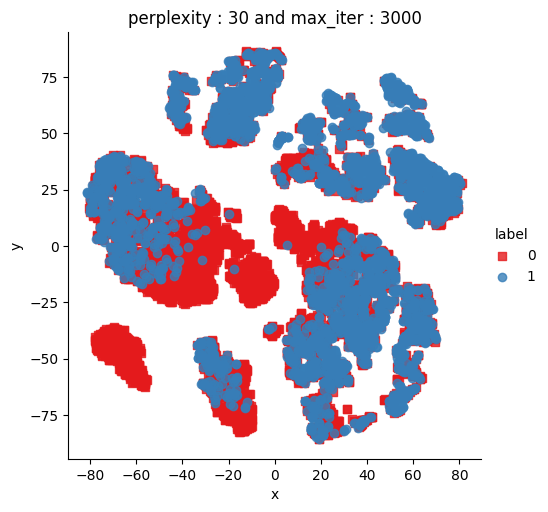

In [ ]:
df = pd.DataFrame({'x':tsne_2d[:,0], 'y':tsne_2d[:,1] ,'label':y.values.flatten()})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 3000))
plt.show()